# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena

**Estudiante:** Francisco Guíñez

## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    548      0 --:--:-- --:--:-- --:--:--   548
100 1546k  100 1546k    0     0  1714k      0 --:--:-- --:--:-- --:--:-- 1714k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    992      0 --:--:-- --:--:-- --:--:--   992
100  385k  100  385k    0     0   692k      0 --:--:-- --:--:-- --:--:--  692k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1469      0 --:--:-- --:--:-- --:--:--  1469
100  230k  100  230k    0     0   560k      0 --:--:-- --:--:-- --:--:--  560k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
!pip install seaborn --upgrade

Requirement already up-to-date: pyreclab in /usr/local/lib/python3.6/dist-packages (0.1.15)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

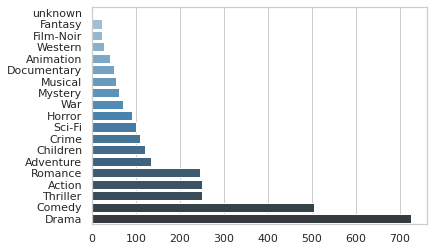

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** SVD Funciona por medio de la búsqueda del descenso de gradiante, por lo que se podría entender como una versión muy básica de red neuronal. Por ello, el modelo tiene parámetros por aprender, para lo cual utiliza el gradiante.

El método train en `pyreclab` realiza la implementación del modelo descrito, calculando el descenso de gradiante y dejando el modelo listo para generar recomendaciones. Además, este proceso se puede personalizar por medio de parámetros, variando por ejemplo la cantidad de factores o el valor de lambda.

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [14]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [15]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7201116150795297
RMSE: 0.9137460270500354


In [16]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.1171149662829822
NDCG@20: 0.06478958124202909


In [17]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1512, 1449, 169, 408, 1467, 1398, 1450, 64, 483, 1642, 189, 963, 1367, 1137, 134, 12, 114, 318, 923, 1653]


In [18]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1398,Anna (1996),13-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Anna%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió:

In [19]:
def testing(model):
    return model.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)
    
def recommend(model):
    return svd.testrec(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2,
                                topn=20,
                                relevance_threshold=2,
                                includeRated=False)

Variación `factors`

In [20]:
factors = [10, 50, 100, 200, 500]

for f in factors:
    svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
    _, mae, rmse = testing(svd)
    _, maprec, ndcg = recommend(svd)

    print(f'[SVG] factors={f}')
    print(f'MAE: {mae}\nRMSE: {rmse}')
    print('MAP: {}\nNDCG@{}: {}\n'.format(maprec, 20, ndcg))

[SVG] factors=10
MAE: 0.7211284422472127
RMSE: 0.9191149196009872
MAP: 0.076070265751366
NDCG@20: 0.041373669807267456

[SVG] factors=50
MAE: 0.7220317556515902
RMSE: 0.9167062257529399
MAP: 0.104245530680592
NDCG@20: 0.05794524396332996

[SVG] factors=100
MAE: 0.7202737440001651
RMSE: 0.9140013855507155
MAP: 0.12752845836571264
NDCG@20: 0.0662787337894375

[SVG] factors=200
MAE: 0.7205746360793732
RMSE: 0.9138049119287247
MAP: 0.12968137376620748
NDCG@20: 0.0735052063791952

[SVG] factors=500
MAE: 0.7201012420096438
RMSE: 0.9131730940858512
MAP: 0.15096831462834354
NDCG@20: 0.08482718465421714



Se ve que no hay un gran cambio en las métricas de error al variar factores, pero si una mejora en las recomendaciones al rededor del valor 100.

Variación `maxiter`

In [21]:
maxiter = [10, 50, 100, 200, 500]

for f in maxiter:
    svd.train(factors=100, maxiter=f, lr=0.01, lamb=0.1)
    _, mae, rmse = testing(svd)
    _, maprec, ndcg = recommend(svd)

    print(f'[SVG] maxiter={f}')
    print(f'MAE: {mae}\nRMSE: {rmse}')
    print('MAP: {}\nNDCG@{}: {}\n'.format(maprec, 20, ndcg))

[SVG] maxiter=10
MAE: 0.7462131234650197
RMSE: 0.9447397324615897
MAP: 0.16051829989408245
NDCG@20: 0.09953687870828047

[SVG] maxiter=50
MAE: 0.7193590090226945
RMSE: 0.9126934553915961
MAP: 0.12927715892566263
NDCG@20: 0.07460964248169191

[SVG] maxiter=100
MAE: 0.720934139994547
RMSE: 0.9153198899430139
MAP: 0.11718513585509177
NDCG@20: 0.06335022463608667

[SVG] maxiter=200
MAE: 0.7211853610013728
RMSE: 0.9152315526122614
MAP: 0.09722528891665679
NDCG@20: 0.05302129507743959

[SVG] maxiter=500
MAE: 0.7216915386766114
RMSE: 0.9157923303696994
MAP: 0.11000810905533336
NDCG@20: 0.060093156351258996



El mejor valor parece ser 10

Variación `lr`

In [27]:
lr = [0.005, 0.01, 0.05, 0.1]

for f in lr:
    svd.train(factors=100, maxiter=100, lr=f, lamb=0.1)
    _, mae, rmse = testing(svd)
    _, maprec, ndcg = recommend(svd)

    print(f'[SVG] lr={f}')
    print(f'MAE: {mae}\nRMSE: {rmse}')
    print('MAP: {}\nNDCG@{}: {}\n'.format(maprec, 20, ndcg))

[SVG] lr=0.005
MAE: 0.7183223159756058
RMSE: 0.9116942908229625
MAP: 0.1298705057760931
NDCG@20: 0.07671886732235143

[SVG] lr=0.01
MAE: 0.7203782257250562
RMSE: 0.9148372014356583
MAP: 0.11862206815583391
NDCG@20: 0.06394322182981096

[SVG] lr=0.05
MAE: 0.7381981289298458
RMSE: 0.9321484794809393
MAP: 0.12375621663837852
NDCG@20: 0.06543968441959509

[SVG] lr=0.1
MAE: 0.76456511721348
RMSE: 0.961913587757087
MAP: 0.12544781975429112
NDCG@20: 0.05975263412792198



No parece producir grandes cambios, pero mientras más pequeño mejora un poco.

Variación `lamb`

In [28]:
lamb = [0.005, 0.01, 0.05, 0.1]

for f in lamb:
    svd.train(factors=100, maxiter=100, lr=f, lamb=f)
    _, mae, rmse = testing(svd)
    _, maprec, ndcg = recommend(svd)

    print(f'[SVG] lamb={f}')
    print(f'MAE: {mae}\nRMSE: {rmse}')
    print('MAP: {}\nNDCG@{}: {}\n'.format(maprec, 20, ndcg))

[SVG] lamb=0.005
MAE: 0.8309424543597004
RMSE: 1.0603494368403572
MAP: 0.1698674628939345
NDCG@20: 0.09622886249366736

[SVG] lamb=0.01
MAE: 0.8052890772865157
RMSE: 1.0225320319576425
MAP: 0.17499393808834138
NDCG@20: 0.09729706820435911

[SVG] lamb=0.05
MAE: 0.7429872980807958
RMSE: 0.9429134171573215
MAP: 0.18360156962239235
NDCG@20: 0.09278900358175038

[SVG] lamb=0.1
MAE: 0.7645573752876019
RMSE: 0.9619384749399069
MAP: 0.12486116012835023
NDCG@20: 0.059418708034619516



Similar a `lr`, sin embargo en torno al valor 0.05 se obtuvieron los mejores resultados.

**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [30]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
    svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
    
    predlist, mae, rmse = svd.test(input_file='u2.test',
                                  dlmchar=b'\t',
                                  header=False,
                                  usercol=0,
                                  itemcol=1,
                                  ratingcol=2)
    
    mae_values.append(mae)
    rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7199185562935012, 0.7196936873878315, 0.7197582571253963]
[0.9139137814785849, 0.9130733653577273, 0.9130856831259478]


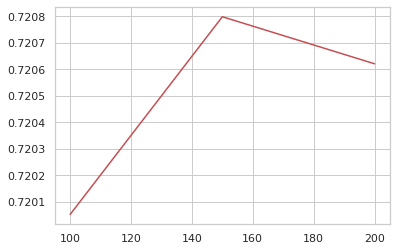

In [25]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

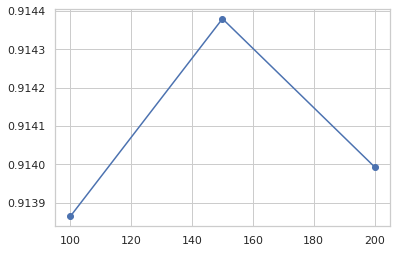

In [26]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

`maxiter`

[0.7463604165257796, 0.7250624545223519, 0.7198590366912799, 0.7195738859768318, 0.7202697860336752, 0.7209032428951708, 0.7216773654060995]


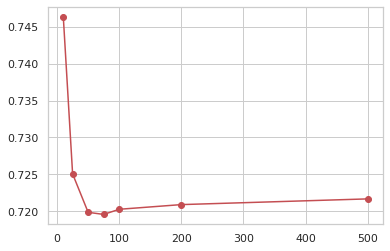

[0.9444828986613057, 0.919567978929737, 0.9127248606624466, 0.913191864112173, 0.9136794880017488, 0.9148485900730976, 0.9156834526028214]


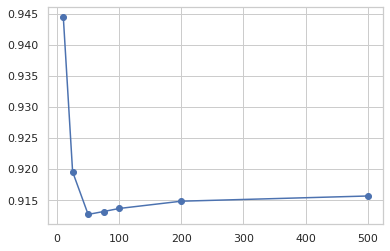

In [40]:
maxiter_values = [10, 25, 50, 75, 100, 200, 500] # definir distintos numeros
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for v in maxiter_values:
    svd.train(factors=100, maxiter=v, lr=0.01, lamb=0.1)
    _, mae, rmse = testing(svd)
    mae_values.append(mae)
    rmse_values.append(rmse)

print(mae_values)
plt.plot(maxiter_values, mae_values, 'ro-')
plt.show()

print(rmse_values)
plt.plot(maxiter_values, rmse_values, 'bo-')
plt.show()

[0.7899366633603083, 0.743574717887208, 0.7191394727208099, 0.7210754876298248, 0.7378319131430305, 0.7645033893777876]


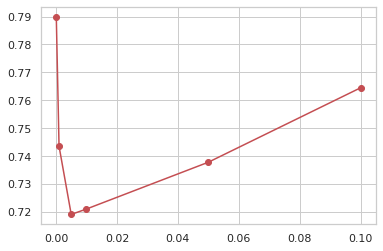

[0.9884130229033427, 0.9404488164597316, 0.9129799328111844, 0.9150155237607338, 0.9317559714643595, 0.9619222154426398]


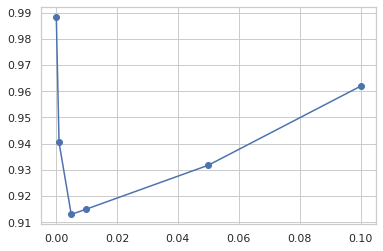

In [39]:
lr_values = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1] # definir distintos numeros
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for v in lr_values:
    svd.train(factors=100, maxiter=100, lr=v, lamb=0.1)
    _, mae, rmse = testing(svd)
    mae_values.append(mae)
    rmse_values.append(rmse)

print(mae_values)
plt.plot(lr_values, mae_values, 'ro-')
plt.show()

print(rmse_values)
plt.plot(lr_values, rmse_values, 'bo-')
plt.show()

[0.838247827309951, 0.809706000614455, 0.7342752949507628, 0.7240402743029932, 0.7209980974398902, 0.728715230442958, 0.7424834252613266, 0.7609848932453956]


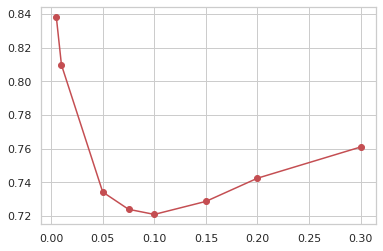

[1.0675196839759307, 1.0298708933253218, 0.9353667720774411, 0.9203971381279599, 0.915398445791415, 0.9205938460838167, 0.9347789862560947, 0.9541196779368325]


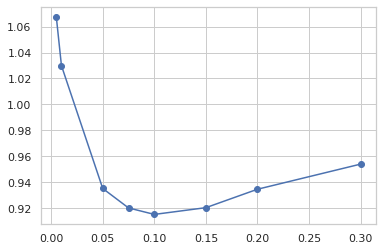

In [41]:
lamb_values = [0.005, 0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3] # definir distintos numeros
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for v in lamb_values:
    svd.train(factors=100, maxiter=100, lr=0.01, lamb=v)
    _, mae, rmse = testing(svd)
    mae_values.append(mae)
    rmse_values.append(rmse)

print(mae_values)
plt.plot(lamb_values, mae_values, 'ro-')
plt.show()

print(rmse_values)
plt.plot(lamb_values, rmse_values, 'bo-')
plt.show()